<a href="https://colab.research.google.com/github/apanand/UChicago-MSADS/blob/main/Apoorv_Prophet_Orbit_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##EDA

In [ ]:
!pip install basemap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 936.0/936.0 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━ 22.0/30.5 MB 26.6 MB/s eta 0:00:01
ERROR: Operation cancelled by user
^C


In [6]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
#from mpl_toolkits.basemap import Basemap
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error



In [7]:
# prompt: mount my google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
root_dir = "/content/drive/Shareddrives/Time Series Project"

In [9]:
df = pd.read_csv(f'{root_dir}/Copy of Zillow.csv')

In [10]:
df

,RegionID,SizeRank,RegionName,RegionType,StateName,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,...,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30
0,102001,0,United States,country,NaN,101618.236677,101875.512312,102420.908619,103162.600775,103963.420050,...,348069.310568,346640.705041,347682.022487,351642.474335,355688.086847,358676.903906,360799.615050,361980.201288,361869.160294,360999.272867
1,394913,1,"New York, NY",msa,NY,177882.794254,177150.053044,176980.042506,177203.615607,178062.588692,...,634251.933795,634828.979135,638361.304928,645878.291010,653811.362311,658582.516733,664883.299081,671039.705036,675073.689031,677136.065513
2,753899,2,"Los Angeles, CA",msa,CA,183180.792413,184312.765430,185169.480595,185532.625593,186167.385435,...,909409.662698,908782.597321,915506.937576,933681.989348,949264.684779,958033.549675,962679.763257,965147.476348,961961.814899,959076.664436
3,394463,3,"Chicago, IL",msa,IL,128458.116409,127870.624477,129273.056822,130939.169879,132485.718642,...,304870.928795,303694.178265,305126.719110,309818.618801,315094.433810,318737.761013,322275.960013,324457.198430,324895.673257,324336.630057
4,394514,4,"Dallas, TX",msa,TX,108315.386079,108984.191377,110023.639047,110862.228110,111363.526661,...,366357.624701,365571.199475,367517.430720,371407.110353,375082.417755,376623.820020,377208.851244,376659.479337,374678.909741,372890.986861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
890,753929,935,"Zapata, TX",msa,TX,NaN,NaN,NaN,NaN,NaN,...,113238.813915,109665.988194,109262.920568,111888.811029,116281.318566,118839.769509,119893.881545,120316.305620,119791.430354,118532.283990
891,394743,936,"Ketchikan, AK",msa,AK,NaN,NaN,NaN,NaN,NaN,...,374893.881646,374778.790956,375465.699349,378234.555396,382705.730697,386068.118208,388268.283945,390673.816677,391884.221906,393078.653245
892,753874,937,"Craig, CO",msa,CO,67973.006808,68321.363493,69121.337438,69355.236182,70504.925773,...,280488.124888,277577.435561,277621.030638,278923.833664,281037.432503,284688.133338,286391.768839,288555.831056,290022.284921,292135.093914
893,395188,938,"Vernon, TX",msa,TX,NaN,NaN,NaN,NaN,NaN,...,85233.222735,85826.433553,85256.354185,86582.456771,89223.762941,90257.394590,90491.987162,90699.932854,89248.242831,85928.769941


In [ ]:
# Melt the DataFrame to make it long format for easier date manipulation
df_long = df.melt(id_vars=['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName'],
                  var_name='Date', value_name='Listings')


In [ ]:
# Convert Date column to datetime format
df_long['Date'] = pd.to_datetime(df_long['Date'], errors='coerce')

In [ ]:
# Extract the year from the date
df_long['Year'] = df_long['Date'].dt.year

In [ ]:
# Group by city and year, then sum the listings
city_year_data = df_long.groupby(['RegionName', 'Year']).agg({'Listings': 'sum'}).reset_index()


In [ ]:
# Load a GeoDataFrame for the U.S. map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
usa = world[world.name == 'United States']

AttributeError: The geopandas.dataset has been deprecated and was removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.

##Uber Orbit DLT Model

In [1]:
!pip install orbit-ml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 446.9/446.9 kB 8.4 MB/s eta 0:00:00
  Installing build dependencies ... canceled
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 377, in run
    requirement_set = resolver.resolve(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 95, in resolve
    result = self._result = resolver.resolve(
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/resolvelib/resolvers.py", line 546, in resolve
    state = resolution.resolve(requirements, max_rounds=max_rounds)
  File "/usr/local/lib/python3.10/dis

In [ ]:
from orbit.models.dlt import DLT
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
# Extract United States data
us_data = df[df['RegionName'] == 'United States'].iloc[:, 5:].T
us_data.columns = ['HomeValue']
us_data.index = pd.to_datetime(us_data.index)

In [ ]:
# Add time as a column
us_data = us_data.reset_index().rename(columns={'index': 'Date'})

In [ ]:
us_data

,Date,HomeValue
0,1996-02-29,101618.236677
1,1996-03-31,101875.512312
2,1996-04-30,102420.908619
3,1996-05-31,103162.600775
4,1996-06-30,103963.420050
...,...,...
339,2024-05-31,358676.903906
340,2024-06-30,360799.615050
341,2024-07-31,361980.201288
342,2024-08-31,361869.160294


In [ ]:
# Create dummy variables for shocks
us_data['FinancialCrisis2008'] = us_data['Date'].between('2008-01-01', '2009-12-31').astype(int)
us_data['Covid19'] = us_data['Date'].between('2020-01-01', '2021-12-31').astype(int)

In [ ]:
# Prepare data for Orbit
us_data = us_data.rename(columns={'Date': 'date', 'HomeValue': 'response'})

In [ ]:
# Split into training and testing data
train_data = us_data[us_data['date'] < '2022-01-01']
test_data = us_data[us_data['date'] >= '2022-01-01']

In [ ]:
# Initialize and fit the DLT model
dlt = DLT(
    response_col='response',
    date_col='date',
    regressor_col=['FinancialCrisis2008', 'Covid19'],
    seasonality=12,
    seed=42,
)

In [ ]:
dlt.fit(train_data)

2024-11-16 18:43:11 - orbit - INFO - Sampling (CmdStanPy) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (CmdStanPy) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [ ]:
# Forecast for the next three years
future_dates = pd.date_range(start='2025-01-01', periods=36, freq='M')
forecast_data = pd.DataFrame({'date': future_dates})

# Add regressor columns to forecast_data, initializing them to 0 for future dates
forecast_data['FinancialCrisis2008'] = 0
forecast_data['Covid19'] = 0  # Assuming these events are not occurring in the future

# Forecast using the DLT model
forecast = dlt.predict(forecast_data)

<ipython-input-51-1666c7e5b427>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start='2025-01-01', periods=36, freq='M')


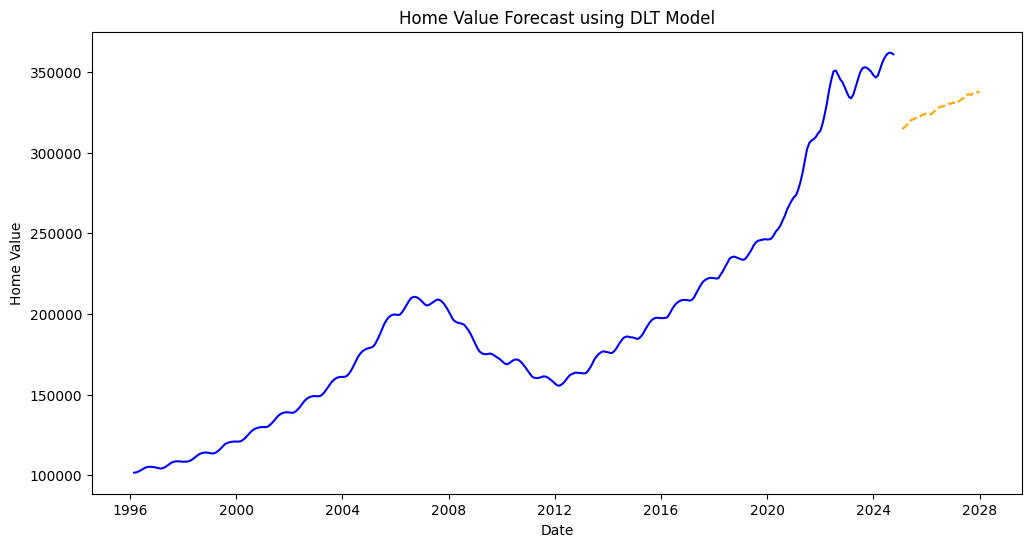

In [ ]:
# Plot the observed data and forecast
plt.figure(figsize=(12, 6))
plt.plot(us_data['date'], us_data['response'], label='Observed', color='blue')
plt.plot(forecast['date'], forecast['prediction'], label='Forecast', linestyle='--', color='orange')
plt.title('Home Value Forecast using DLT Model')
plt.xlabel('Date')
plt.ylabel('Home Value')
#plt.legend()
plt.show()

In [ ]:
# Split into training and testing data
train_data = us_data[us_data['date'] < '2016-01-01']
test_data = us_data[(us_data['date'] > '2016-12-31') & (us_data['date'] < '2019-01-01')]

In [ ]:
dlt.fit(train_data)

2024-11-20 00:52:25 - orbit - INFO - Sampling (CmdStanPy) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (CmdStanPy) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [ ]:
# Forecast for the next three years
future_dates = pd.date_range(start='2016-01-01', periods=36, freq='M')
forecast_data = pd.DataFrame({'date': future_dates})

# Add regressor columns to forecast_data, initializing them to 0 for future dates
forecast_data['FinancialCrisis2008'] = 0
forecast_data['Covid19'] = 0  # Assuming these events are not occurring in the future

# Forecast using the DLT model
forecast = dlt.predict(forecast_data)

<ipython-input-24-8eb0864b8208>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start='2016-01-01', periods=36, freq='M')


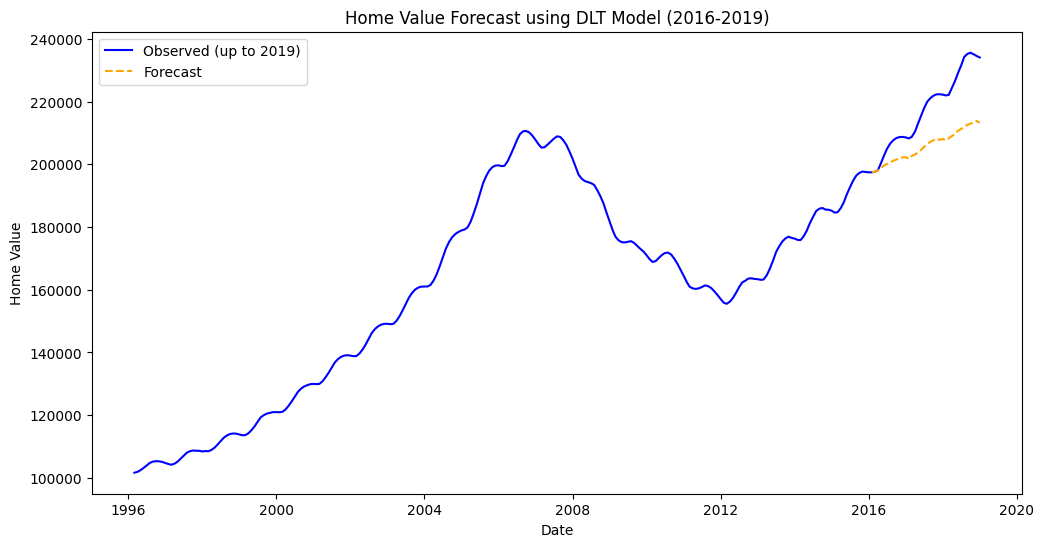

In [ ]:
# Filter data to include only actual values up to 2019-12-31
truncated_data = us_data[us_data['date'] <= '2019-01-01']

# Plot the observed data (truncated) and forecast
plt.figure(figsize=(12, 6))
plt.plot(truncated_data['date'], truncated_data['response'], label='Observed (up to 2019)', color='blue')
plt.plot(forecast['date'], forecast['prediction'], label='Forecast', linestyle='--', color='orange')
plt.title('Home Value Forecast using DLT Model (2016-2019)')
plt.xlabel('Date')
plt.ylabel('Home Value')
plt.legend()
plt.show()


##Facebook Prophet Package

In [2]:
!pip install prophet

In [3]:
from prophet import Prophet

In [11]:
# Filter the dataset for the "United States" row
us_data = df[df['RegionName'] == 'United States']

In [12]:
# Transpose and reshape the data for Prophet
us_data = us_data.drop(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName'], axis=1).transpose()
us_data.reset_index(inplace=True)
us_data.columns = ['ds', 'y']

In [13]:
# Convert 'ds' column to datetime
us_data['ds'] = pd.to_datetime(us_data['ds'])

In [14]:
train_data = us_data.iloc[:-36]  # Use all but the last 3 years for training
test_data = us_data.iloc[-36:]  # Use the last 3 years for testing

In [15]:
model = Prophet()

In [16]:
model.fit(train_data)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3qtple62/7mfsqdd6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3qtple62/jkekkoht.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88367', 'data', 'file=/tmp/tmp3qtple62/7mfsqdd6.json', 'init=/tmp/tmp3qtple62/jkekkoht.json', 'output', 'file=/tmp/tmp3qtple62/prophet_modelc0it1l4u/prophet_model-20241204012822.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:28:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:28:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [17]:
# Create a dataframe for future dates (next 3 years)
future = model.make_future_dataframe(periods=36, freq='M')

/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


In [18]:
# Forecast future values
forecast = model.predict(future)

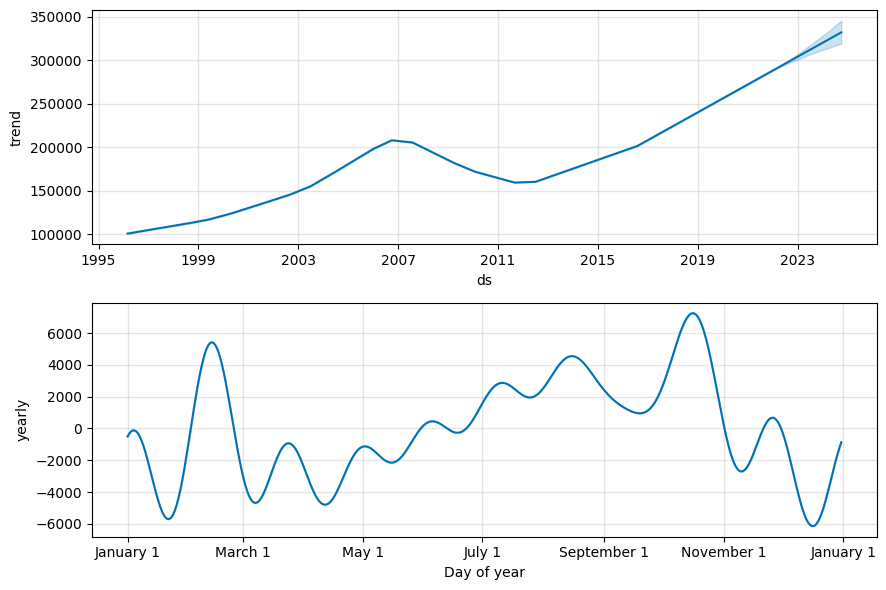

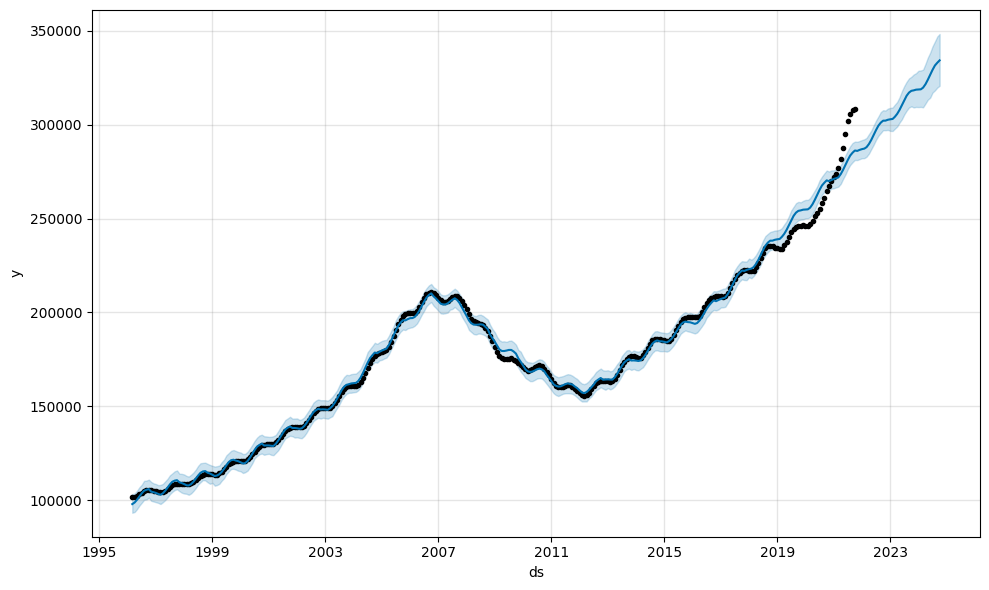

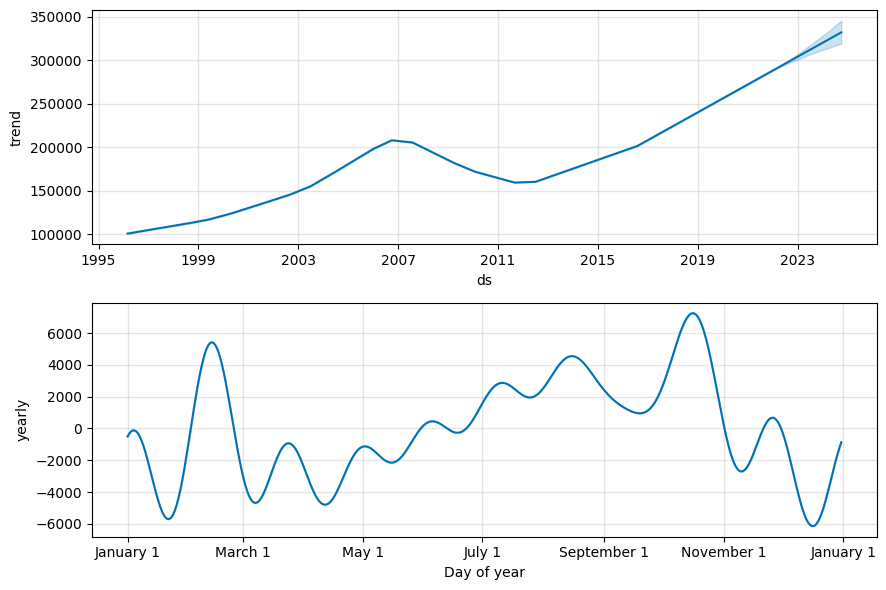

In [19]:
model.plot(forecast)
model.plot_components(forecast)

In [20]:
print("\nForecast for the next 3 years:")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(36))



Forecast for the next 3 years:
            ds           yhat     yhat_lower     yhat_upper
308 2021-10-31  286030.489893  281142.687048  290883.292631
309 2021-11-30  286574.174307  281639.378377  291293.301317
310 2021-12-31  286980.082299  282119.413260  291816.485749
311 2022-01-31  287269.272269  282183.416720  292246.547960
312 2022-02-28  288032.981664  282960.142534  292960.378477
313 2022-03-31  289709.628731  284607.248942  294959.750136
314 2022-04-30  291885.475988  286966.931903  296833.648740
315 2022-05-31  294488.557362  289323.719611  299572.558853
316 2022-06-30  297082.872470  291902.844252  302112.803855
317 2022-07-31  299467.203639  294101.019445  304340.011951
318 2022-08-31  301087.031512  295563.858448  306708.655069
319 2022-09-30  302127.585190  297076.274479  307701.016640
320 2022-10-31  302157.415500  297036.435558  307552.657295
321 2022-11-30  302615.255812  297213.976054  308564.115176
322 2022-12-31  302865.930522  296697.967515  308917.766347
323 2023

In [21]:
# Evaluate model accuracy on the test set
# Merge forecast with actual test data
forecast_test = forecast.set_index('ds').join(test_data.set_index('ds'), how='inner', lsuffix='_forecast', rsuffix='_actual')

In [22]:
# Calculate accuracy metrics
mae = mean_absolute_error(forecast_test['y'], forecast_test['yhat'])
mse = mean_squared_error(forecast_test['y'], forecast_test['yhat'])
rmse = np.sqrt(mse)

In [23]:
print("\nModel Accuracy Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")



Model Accuracy Metrics:
Mean Absolute Error (MAE): 34852.62
Mean Squared Error (MSE): 1270478500.05
Root Mean Squared Error (RMSE): 35643.77


In [24]:
summary_stats = forecast_test[['y', 'yhat']].describe()
print("\nSummary Statistics for Actual vs Forecasted Values:")
print(summary_stats)


Summary Statistics for Actual vs Forecasted Values:
                   y           yhat
count      36.000000      36.000000
mean   343389.612869  308536.994240
std     13999.805183   14483.488868
min    309825.420230  286030.489893
25%    337090.683879  298871.120846
50%    347161.363764  306795.140343
75%    351782.392818  318771.297874
max    361980.201288  334260.780302


##Prophet with Tuned Hyperparameters and Log Transformation

In [25]:
# Log-transform the target variable
train_data['y'] = np.log(train_data['y'])
test_data['y'] = np.log(test_data['y'])  # Log transform test data for consistency

<ipython-input-25-e9ccfc623bbb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['y'] = np.log(train_data['y'])
<ipython-input-25-e9ccfc623bbb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['y'] = np.log(test_data['y'])  # Log transform test data for consistency


In [26]:
# Initialize the Prophet model with tuned parameters
model = Prophet(
    changepoint_prior_scale=0.05,  # Increase to make trend more flexible
    seasonality_prior_scale=10,   # Adjust seasonality flexibility
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)

In [27]:
# Fit the model on the training data
model.fit(train_data)


DEBUG:cmdstanpy:input tempfile: /tmp/tmp3qtple62/rlasvw11.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3qtple62/lbxih_7d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29866', 'data', 'file=/tmp/tmp3qtple62/rlasvw11.json', 'init=/tmp/tmp3qtple62/lbxih_7d.json', 'output', 'file=/tmp/tmp3qtple62/prophet_model36845b6g/prophet_model-20241204012943.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:29:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:29:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [28]:
# Create future dataframe and make predictions
future = model.make_future_dataframe(periods=36, freq='M')
forecast = model.predict(future)

/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


In [29]:
# Back-transform predictions from log scale to original scale
forecast['yhat'] = np.exp(forecast['yhat'])
forecast['yhat_lower'] = np.exp(forecast['yhat_lower'])
forecast['yhat_upper'] = np.exp(forecast['yhat_upper'])

In [30]:
# Merge forecast with actual test data (in original scale)
test_data['y'] = np.exp(test_data['y'])  # Revert test data back to original scale
forecast_test = forecast.set_index('ds').join(test_data.set_index('ds'), how='inner', lsuffix='_forecast', rsuffix='_actual')


<ipython-input-30-288daa4a8267>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['y'] = np.exp(test_data['y'])  # Revert test data back to original scale


In [31]:
# Calculate accuracy metrics
mae = mean_absolute_error(forecast_test['y'], forecast_test['yhat'])
mse = mean_squared_error(forecast_test['y'], forecast_test['yhat'])
rmse = np.sqrt(mse)


In [32]:
print("\nTuned Model Accuracy Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Tuned Model Accuracy Metrics:
Mean Absolute Error (MAE): 24331.70
Mean Squared Error (MSE): 701651897.03
Root Mean Squared Error (RMSE): 26488.71


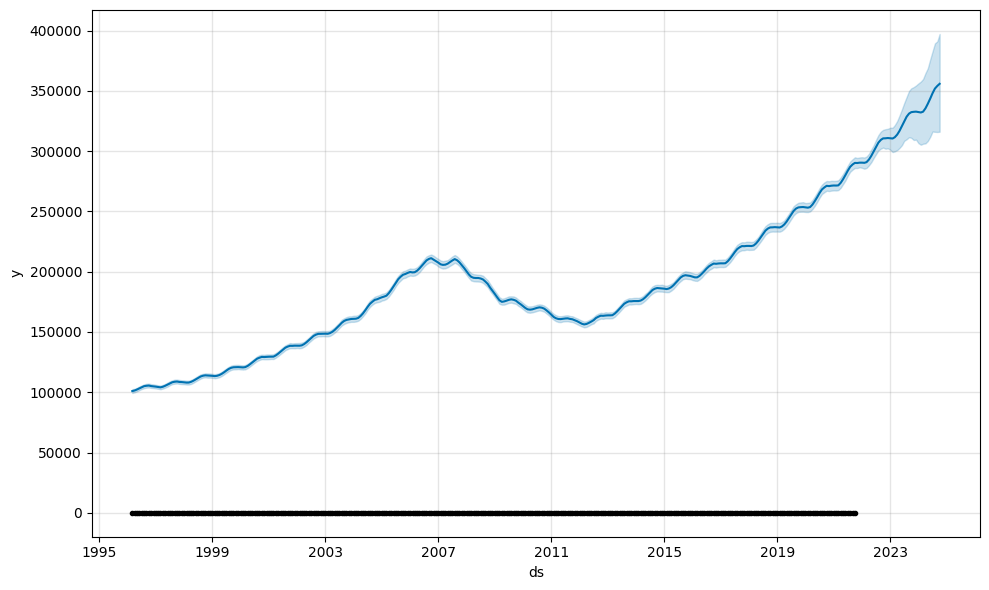

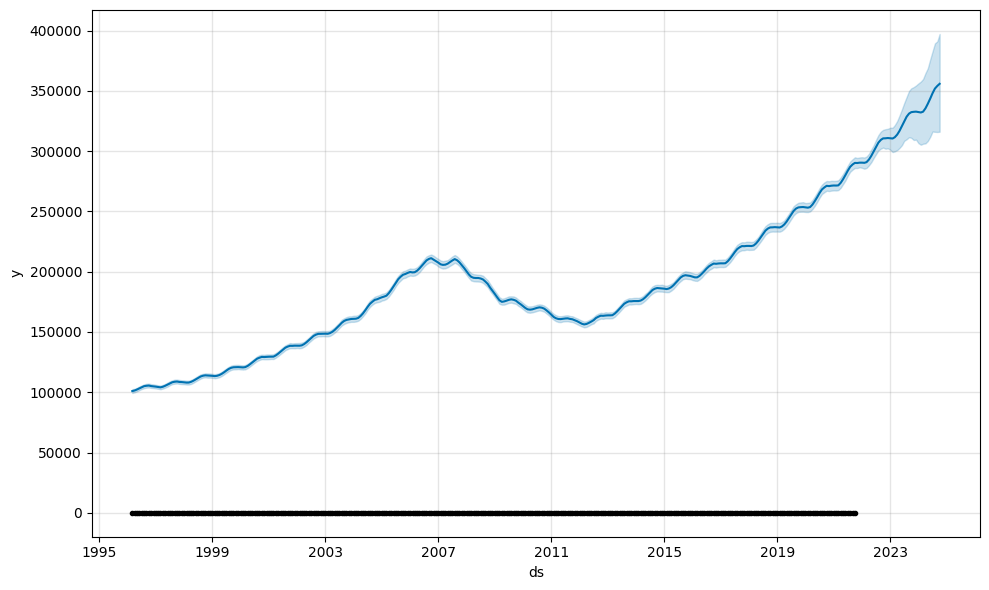

In [ ]:
# Plot the forecast
#model.plot(forecast)
#model.plot_components(forecast)

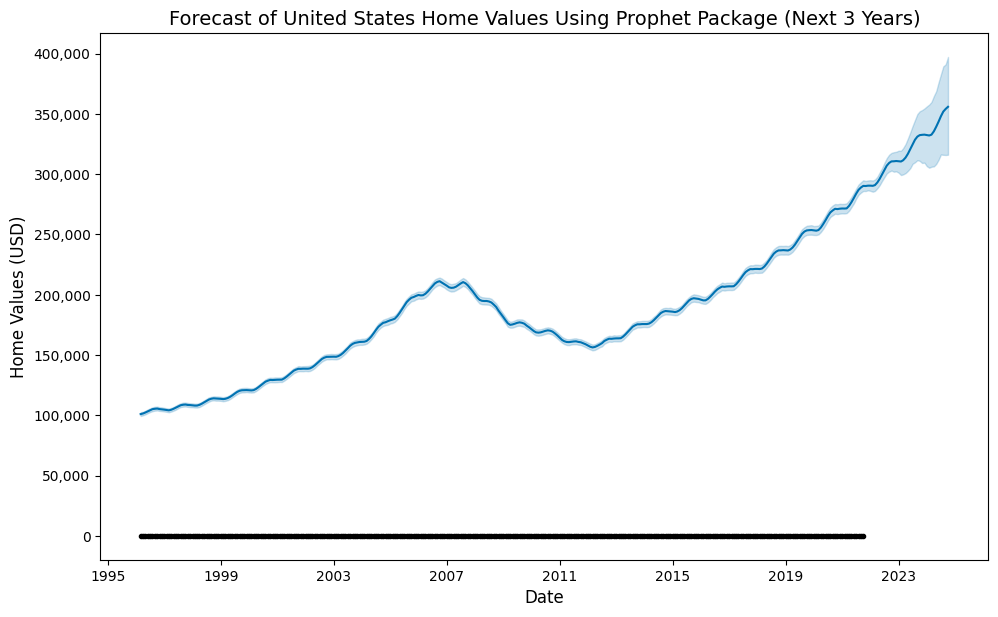

In [ ]:
# Customize the Prophet forecast plot for presentation
fig = model.plot(forecast)

# Get the axes from the figure
ax = fig.gca()

# Set title and axis labels
ax.set_title('Forecast of United States Home Values Using Prophet Package (Next 3 Years)', fontsize=14)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Home Values (USD)', fontsize=12)

# Format y-axis labels with commas for better readability
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: f'{int(x):,}'))

# Remove gridlines for a cleaner look
ax.grid(False)

# Show the plot
plt.show()

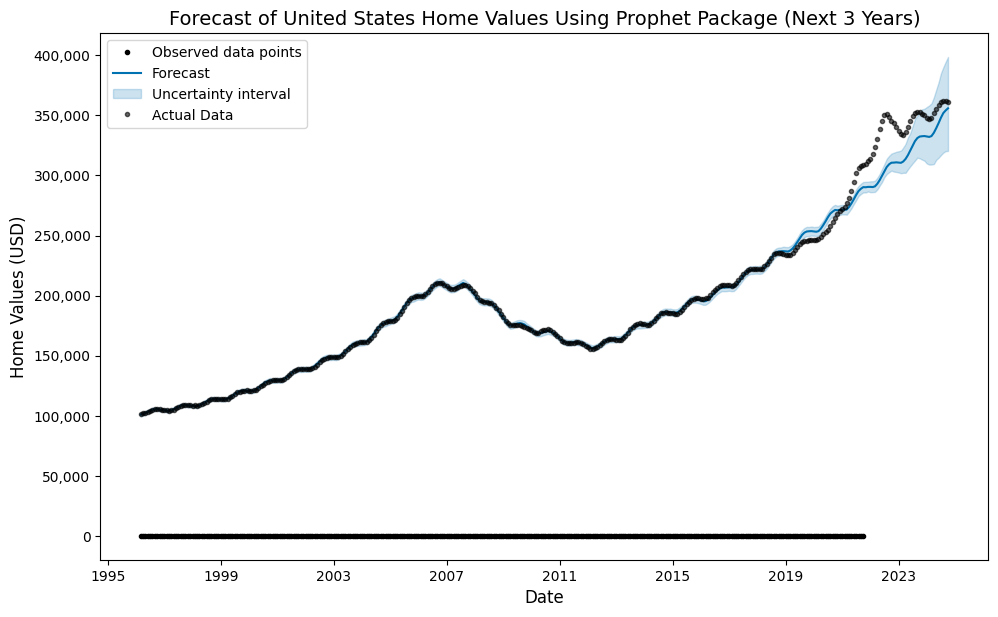

In [33]:
# Customize the Prophet forecast plot for presentation
fig = model.plot(forecast)

# Add actual data to the forecast plot
ax = fig.gca()  # Get the axes from the figure
ax.plot(us_data['ds'], us_data['y'], 'k.', label='Actual Data', alpha=0.6)  # Add actual data points

# Set title and axis labels
ax.set_title('Forecast of United States Home Values Using Prophet Package (Next 3 Years)', fontsize=14)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Home Values (USD)', fontsize=12)

# Format y-axis labels with commas for better readability
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: f'{int(x):,}'))

# Remove gridlines for a cleaner look
ax.grid(False)

# Add legend for clarity
ax.legend()

# Show the plot
plt.show()
